# packages required to run notebook : 

- pip install umap-learn
- pip install -U sentence-transformers
- pip install hdbscan
- pip install bertopic 

 Be carefull don't use pip install bertopic[flair] --user as it may cause issues with your environment and other packages ( uninstalled some of ours)



In [1]:
import pandas as pd
import numpy as np
import os
import csv
import time

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import umap
from sklearn.decomposition import PCA
import random
import math

In [2]:
from sentence_transformers import SentenceTransformer, util

In [3]:
from sklearn.datasets import make_blobs, make_moons
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [4]:
#data = pd.read_json('../Valerian/Data_sample/quotes-2019-nytimes.json.bz2', lines=True, compression='bz2')

In [3]:
#Concatenate the dataframes obtained from each of the pickle file. 
files = ('QOI_2015_DF.pkl','QOI_2016_DF.pkl','QOI_2017_DF.pkl','QOI_2018_DF.pkl','QOI_2019_DF.pkl', 'QOI_2020_DF.pkl')
data = pd.concat([pd.read_pickle('../generated_data/'+fp) for fp in files], ignore_index=True)

In [15]:
PATH_GENERATED_DATA = '../generated_data/'

In [16]:
# use enriched dataframe instead : 

data = pd.read_pickle(PATH_GENERATED_DATA+'df_enriched.pkl', compression='infer', storage_options=None)

In [11]:
# save all the selected quotes dataframe to pickle protocol 4 for google colab :
# data.to_pickle('../generated_data/'+'prot4_selecteddf', compression='infer', protocol=4, storage_options=None)

In [17]:
# data_reduced_pca = PCA(n_components=2).fit(data['quotation']).transform(data['quotation'])
# data_reduced_tsne = TSNE(n_components=2, random_state=0).fit_transform(data['quotation'])

# fig, axs = plt.subplots(1, 2, figsize=(7,3), sharey=True)

# Plot the data reduced in 2d space with t-SNE
# axs[0].scatter(data_reduced_tsne[:,0], data_reduced_tsne[:,1])
# axs[0].set_title("t-SNE")

# Plot the data reduced in 2d space with PCA
# axs[1].scatter(data_reduced_pca[:,0], data_reduced_pca[:,1])
# axs[1].set_title("PCA")

# Embedding

Source : https://github.com/UKPLab/sentence-transformers/blob/master/examples/applications/clustering/fast_clustering.py#L6

In [33]:
corpus_sentences = data['quotation'].tolist()

In [ ]:
# can take multiple hours if on cpu so just load the file in the next cell
device = 'cpu' # 'cuda' if you have a gpu ( much faster embeddings minutes vs hours)
# Perform data encoding before clustering
model = SentenceTransformer('all-MiniLM-L6-v2', device=device)
data_embeddings = model.encode(corpus_sentences, batch_size=64, show_progress_bar=True, convert_to_tensor=True)

In [ ]:
# save embeddings to file :
np.save(PATH_GENERATED_DATA+'sbert_embeddings.pkl', corpus_embeddings.cpu(), allow_pickle=True, fix_imports=True)

In [34]:
# load the embeddings
with open('../generated_data/'+'sbert_embeddings.pkl.npy', 'rb') as f:
    data_embeddings = np.load(f)

# Dimensionality reduction

In [35]:
data_embeddings.shape # high dimensionality

(55328, 384)

In [36]:
data_embeddings

array([[ 0.08789769,  0.01213884,  0.03986675, ..., -0.07388572,
         0.01323454, -0.00960648],
       [-0.06183886,  0.02651585, -0.00565857, ..., -0.05652884,
         0.0940439 ,  0.06151767],
       [ 0.00620823, -0.03827205,  0.03072297, ..., -0.0363578 ,
         0.09598427, -0.00269855],
       ...,
       [-0.02526036,  0.06176009,  0.04581104, ..., -0.04188322,
        -0.01596625, -0.02076166],
       [ 0.04660336, -0.01821958,  0.0327046 , ...,  0.01187782,
         0.01320529, -0.02019911],
       [ 0.01213297,  0.04776005,  0.04104514, ..., -0.07450268,
        -0.00317091, -0.01296633]], dtype=float32)

### PCA and TSNE

In [34]:
n=1000
# inspired from our ada labs
X_reduced_tsne = TSNE(n_components=2, random_state=0).fit_transform(data_embeddings[0:n])

print("The features of the first sample are: %s" % X_reduced_tsne[0])

C:\ProgramData\Anaconda3\envs\ada\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\ProgramData\Anaconda3\envs\ada\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


The features of the first sample are: [6.492959 4.352534]


In [35]:
X_reduced_pca = PCA(n_components=2).fit(data_embeddings[0:n]).transform(data_embeddings[0:n])

print("The features of the first sample are: %s" % X_reduced_pca[0])

The features of the first sample are: [-0.17813015 -0.18720983]


### K-means & visualisation

Text(0.5, 1.0, 'PCA')

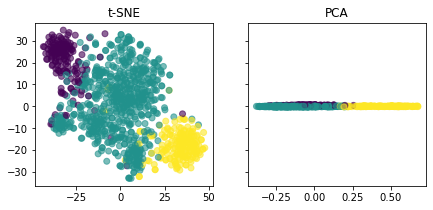

In [36]:
fig, axs = plt.subplots(1, 2, figsize=(7,3), sharey=True)

# Cluster the data in 3 groups
labels = KMeans(n_clusters=3, random_state=0).fit_predict(data_embeddings[0:n])

# Plot the data reduced in 2d space with t-SNE
axs[0].scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=labels, alpha=0.6)
axs[0].set_title("t-SNE")

# Plot the data reduced in 2d space with PCA
axs[1].scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=labels, alpha=0.6)
axs[1].set_title("PCA")

# DBSCAN and visualisation

## DBSACN & t-sne

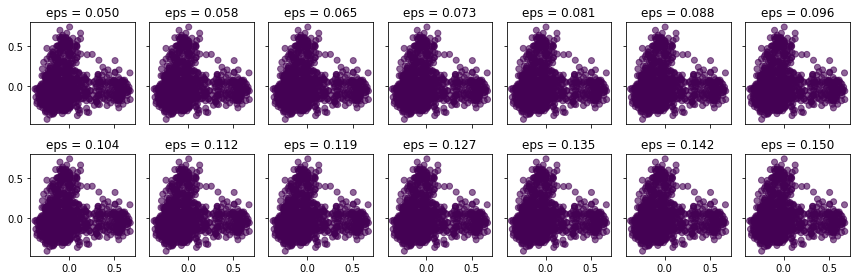

In [38]:
# Create a list of eps
eps_list = np.linspace(0.05, 0.15, 14)

# Compute number of row and columns
COLUMNS = 7
ROWS = math.ceil(len(eps_list)/COLUMNS)

fig, axs = plt.subplots(ROWS, COLUMNS, figsize=(12, 4), sharey=True, sharex=True)

for i in range(0, len(eps_list)):
    eps = eps_list[i]
    
    current_column = i%COLUMNS
    current_row = i//COLUMNS
    
    ax = axs[current_row, current_column]
    labels = DBSCAN(eps=eps).fit_predict(data_embeddings[0:n])
    
    ax.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=labels, alpha=0.6)
    ax.set_title("eps = {:.3f}".format(eps))
    
plt.tight_layout()

### DBSCAN &  PCA

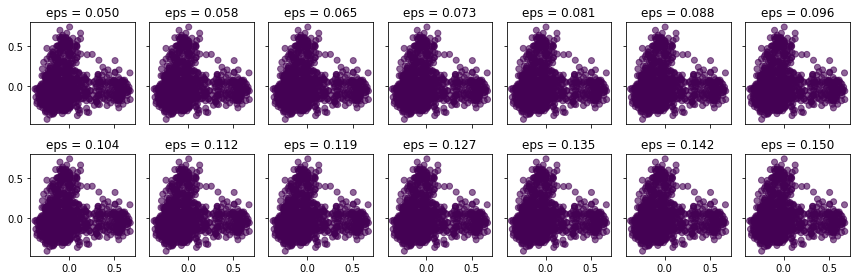

In [40]:
# Create a list of eps
eps_list = np.linspace(0.05, 0.15, 14)

# Compute number of row and columns
COLUMNS = 7
ROWS = math.ceil(len(eps_list)/COLUMNS)

fig, axs = plt.subplots(ROWS, COLUMNS, figsize=(12, 4), sharey=True, sharex=True)

for i in range(0, len(eps_list)):
    eps = eps_list[i]
    
    current_column = i%COLUMNS
    current_row = i//COLUMNS
    
    ax = axs[current_row, current_column]
    labels = DBSCAN(eps=eps).fit_predict(data_embeddings[0:n])
    
    ax.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=labels, alpha=0.6)
    ax.set_title("eps = {:.3f}".format(eps))
    
plt.tight_layout()

Visualisation doesn't bring anything new for n = 1000 maybe will work with more samples

# UMAP

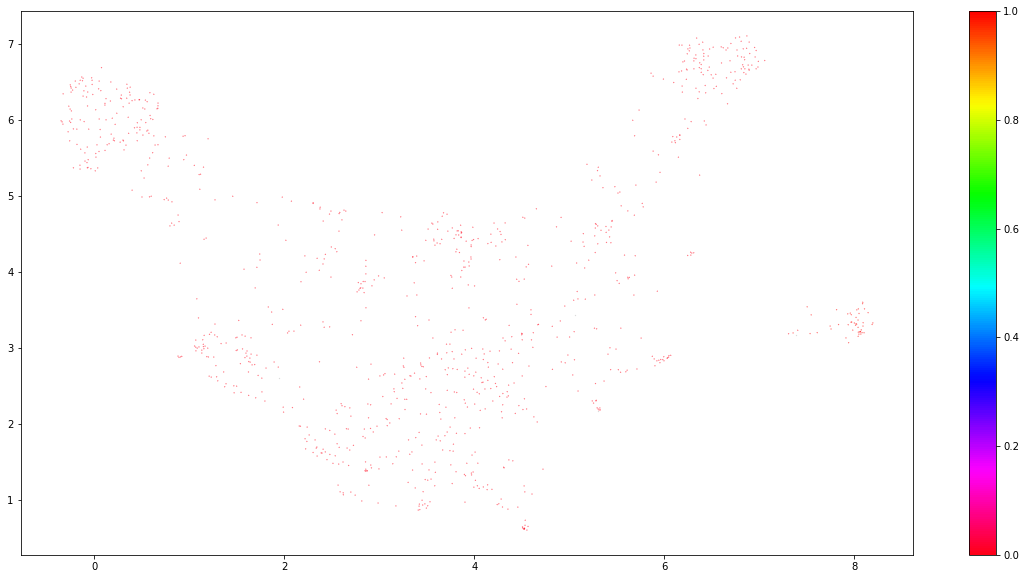

In [48]:
# Source : https://towardsdatascience.com/topic-modeling-with-bert-779f7db187e6

import umap
umap_embeddings = umap.UMAP(n_neighbors=15, 
                            n_components=5, 
                            metric='cosine').fit_transform(data_embeddings[0:n])

import hdbscan
cluster = hdbscan.HDBSCAN(min_cluster_size=15,
                          metric='euclidean',                      
                          cluster_selection_method='eom').fit(umap_embeddings)

# Prepare data
# reduces dimensionality of embeddings
umap_data = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine').fit_transform(data_embeddings[0:n])


result = pd.DataFrame(umap_data, columns=['x', 'y'])

result['labels'] = cluster.labels_

# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.05)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.05, cmap='hsv_r')
plt.colorbar()
plt.show()

# Fast-clustering

In [ ]:
print("Start clustering")
start_time = time.time()

#Two parameters to tune:
#min_cluster_size: Only consider cluster that have at least 25 elements
#threshold: Consider sentence pairs with a cosine-similarity larger than threshold as similar
clusters = util.community_detection(data_embeddings, min_community_size=25, threshold=0.75)

print("Clustering done after {:.2f} sec".format(time.time() - start_time))

In [ ]:
#Print for all clusters the top 3 and bottom 3 elements
for i, cluster in enumerate(clusters):
    print("\nCluster {}, #{} Elements ".format(i+1, len(cluster)))
    for sentence_id in cluster[0:3]:
        print("\t", corpus_sentences[sentence_id])
    print("\t", "...")
    for sentence_id in cluster[-3:]:
        print("\t", corpus_sentences[sentence_id])

In [52]:
#clusters = util.community_detection(data_embeddings[:], min_community_size=25, threshold=0.75)
labels = ['0'] * len(data['quotation'])
for i, cluster in enumerate(clusters):
    for sentence_id in cluster:
        labels[sentence_id] = str(i+1)

In [54]:
data['Cluster_label'] = pd.DataFrame(labels)

In [57]:
(data['Cluster_label']=='0').sum()

52436

In [55]:
data[['Cluster_label','quotation']]

,Cluster_label,quotation
0,0,Anything less than women winning 50 per cent o...
1,0,"more family-friendly and flexible workplaces, ..."
2,0,We need more women and parents in Parliament. ...
3,0,I'd like to congratulate all the winners and f...
4,0,Clearly we have got a long way to go before we...
...,...,...
55323,0,"As a woman in games personally, I found the st..."
55324,0,Over 200 women dropped in to our Edinburgh off...
55325,0,The N-95 masks donated to the Division of EMS ...
55326,0,Men and women are much more likely to be satis...


In [ ]:
for i, cluster in enumerate(clusters):
    print("\nCluster {}, #{} Elements ".format(i+1, len(cluster)))
    for sentence_id in cluster:
        print("\t", corpus_sentences[sentence_id])
    print("\t", "...")

In [67]:
len(cluster)

28

In [ ]:
type(cluster)

In [41]:
import pickle
with open(PATH_GENERATED_DATA+'fast_clustering_clusters.pkl', 'wb') as f:
    pickle.dump(cluster, f)

##### see if tsne & fast clustering come to same conclusion

In [71]:
# DOESN'T WORK FOR NOW

# inspired from our ada labs
# X_reduced_tsne_2 = TSNE(n_components=3, random_state=0).fit_transform(data_embeddings[0:N])

# print("The features of the first sample are: %s" % X_reduced_tsne_2[0])

In [ ]:
#fig, axs = plt.subplots(1, 2, figsize=(7,3), sharey=True)

## Cluster the data in 3 groups
#labels =  ## find way to sort cluster into

# Plot the data reduced in 2d space with t-SNE
#axs[0].scatter(X_reduced_tsne_2[:,0], X_reduced_tsne_2[:,1], c=labels, alpha=0.6)
#axs[0].set_title("t-SNE")

## Topic modelling :

### BERTopic

In [18]:
from bertopic import BERTopic

In [74]:
corpus_sentences = data['quotation'].tolist()

In [20]:
corpus_sentences[1:3]

['more family-friendly and flexible workplaces, and affordable child care, for everyone',
 'We need more women and parents in Parliament. And we need more family-friendly and flexible workplaces, and affordable child care, for everyone.']

In [86]:
# Documentation and links: 
# https://maartengr.github.io/BERTopic/api/bertopic.html#bertopic._bertopic.BERTopic.fit_transform
# https://towardsdatascience.com/interactive-topic-modeling-with-bertopic-1ea55e7d73d8
# https://github.com/MaartenGr/BERTopic/issues/189

topic_model = BERTopic(nr_topics="25")

topics, probs = topic_model.fit_transform(corpus_sentences[0:5000])
corpus_sentences = data['quotation'].tolist()

In [87]:
topic_model.get_topic_info()

,Topic,Count,Name
0,-1,2152,-1_men_work_make_will
1,12,115,12_canada_canadians_canadian_canadas
2,85,106,85_defend_spokesperson_gay_lgbt
3,24,92,24_muslim_muslims_religion_hijab
4,99,91,99_equality_empowerment_together_unesco
...,...,...,...
96,40,11,40_money_doubledipping_wholesale_taxation
97,6,11,6_orchestrated_deliberate_rightwing_attack
98,3,11,3_colour_emmy_else_only
99,34,11,34_fight_countrywhether_defiant_extremists


In [88]:
topic_model.get_topic(0)

[('else', 0.17004703461812354),
 ('only', 0.13713175213487955),
 ('colour', 0.1244766642238748),
 ('color', 0.1102752442853783),
 ('anyone', 0.10319629674606265),
 ('viola', 0.02091101669670753),
 ('davis', 0.02091101669670753),
 ('emmy', 0.011558126762565502),
 ('faa', 0.0),
 ('fabric', 0.0)]

In [89]:
topic_model.get_topic(1)

[('dogs', 0.08445374024814499),
 ('pigs', 0.08265487291186463),
 ('inconvenience', 0.07727395686805325),
 ('employers', 0.06455237827300042),
 ('deserve', 0.061387815882492536),
 ('contest', 0.02381031586151142),
 ('contests', 0.02003516259422763),
 ('housekeeping', 0.02003516259422763),
 ('piggy', 0.02003516259422763),
 ('worst', 0.019702130508582723)]

In [90]:
topic_model.visualize_topics()

In [83]:
topic_model.visualize_barchart()

AttributeError: 'BERTopic' object has no attribute 'visualize_barchart'

In [119]:
import pickle
with open(PATH_GENERATED_DATA+'BERTopic_topic_model.pkl', 'wb') as f:
    pickle.dump(topic_model, f)
with open(PATH_GENERATED_DATA+'BERTopic_topics.pkl', 'wb') as f:
    pickle.dump(topics, f)
with open(PATH_GENERATED_DATA+'BERTopic_probs.pkl', 'wb') as f:
    pickle.dump(probs, f)

In [91]:
# https://github.com/MaartenGr/BERTopic/issues/189
topic_docs = {topic: [] for topic in set(topics)}
for topic, doc in zip(topics, corpus_sentences):
    topic_docs[topic].append(doc)

In [99]:
topic_docs.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, -1])

In [120]:
topics_df = pd.Series(topic_docs, name='quotation').rename_axis('topic').explode().reset_index()

In [121]:
topics_df.head()

,topic,quotation
0,0,It's like Viola Davis said in her Emmy speech:...
1,0,The only thing that separates women of color f...
2,0,The only thing that separates women of color f...
3,0,The only thing that separates women of colour ...
4,0,The only thing that separates women of colour ...


In [127]:
topics_df.to_pickle(PATH_GENERATED_DATA+'BERTopic_topic_topics_df.pkl', compression='infer', protocol=5, storage_options=None)

In [ ]:
# Otherwise we can restrict the number of topics 

In [128]:
test = pd.read_pickle(PATH_GENERATED_DATA+'BERTopic_topic_topics_df.pkl')

In [130]:
test

,topic,quotation
0,0,It's like Viola Davis said in her Emmy speech:...
1,0,The only thing that separates women of color f...
2,0,The only thing that separates women of color f...
3,0,The only thing that separates women of colour ...
4,0,The only thing that separates women of colour ...
...,...,...
4995,-1,He has repeatedly voted to defund Planned Pare...
4996,-1,He has abandoned his district to prop up the a...
4997,-1,Seriously?! Excluding women from Congress is N...
4998,-1,The GOP has been radicalized by those who reli...


## K-means clustering

In [12]:
#silhouettes = []

# Try multiple k
for k in range(20, 21):
    # Cluster the data and assigne the labels
    %time labels = KMeans(n_clusters=k, random_state=10).fit_predict(data_embeddings[0:50000])
    # Get the Silhouette score
    score = silhouette_score(data_embeddings[0:50000], labels)
    #silhouettes.append({"k": k, "score": score}) < ------------------------ UN COMMENT ME

Wall time: 39.5 s


In [34]:
# All the scores calculated for k between 2 and 70
silhouettes = [{'k': 2, 'score': 0.06765938},
 {'k': 3, 'score': 0.08025888},
 {'k': 4, 'score': 0.06857152},
 {'k': 5, 'score': 0.06670063},
 {'k': 6, 'score': 0.06914811},
 {'k': 7, 'score': 0.062064495},
 {'k': 8, 'score': 0.04698455},
 {'k': 9, 'score': 0.048637297},
 {'k': 10, 'score': 0.04555343},
 {'k': 11, 'score': 0.04331785},
 {'k': 12, 'score': 0.0338397},
 {'k': 13, 'score': 0.031613782},
 {'k': 14, 'score': 0.029328056},
 {'k': 15, 'score': 0.02823081},
 {'k': 16, 'score': 0.02709652},
 {'k': 17, 'score': 0.03241088},
 {'k': 18, 'score': 0.023722852},
 {'k': 19, 'score': 0.028849825},
 {'k': 20, 'score': 0.023590626},
 {'k': 21, 'score': 0.024469132},
 {'k': 22, 'score': 0.022494292},
 {'k': 23, 'score': 0.021426162},
 {'k': 24, 'score': 0.02088373},
 {'k': 25, 'score': 0.02193979},
 {'k': 26, 'score': 0.02365849},
 {'k': 27, 'score': 0.021699961},
 {'k': 28, 'score': 0.019700529},
 {'k': 29, 'score': 0.019745713},
 {'k': 30, 'score': 0.018805785},
 {'k': 31, 'score': 0.018140774},
 {'k': 32, 'score': 0.019571794},
 {'k': 33, 'score': 0.019079},
 {'k': 34, 'score': 0.018572222},
 {'k': 35, 'score': 0.018985614},
 {'k': 36, 'score': 0.018342843},
 {'k': 37, 'score': 0.017472241},
 {'k': 38, 'score': 0.017616326},
 {'k': 39, 'score': 0.016665217},
 {'k': 40, 'score': 0.017377011},
 {'k': 41, 'score': 0.015478413},
 {'k': 42, 'score': 0.020415967},
 {'k': 43, 'score': 0.017057404},
 {'k': 44, 'score': 0.017415527},
 {'k': 45, 'score': 0.015795551},
 {'k': 46, 'score': 0.016698632},
 {'k': 47, 'score': 0.015824597},
 {'k': 48, 'score': 0.016085047},
 {'k': 49, 'score': 0.014942225},
 {'k': 50, 'score': 0.016140081},
 {'k': 51, 'score': 0.015462328},
 {'k': 52, 'score': 0.016296005},
 {'k': 53, 'score': 0.016192803},
 {'k': 54, 'score': 0.015256491},
 {'k': 55, 'score': 0.015830258},
 {'k': 56, 'score': 0.016605182},
 {'k': 57, 'score': 0.016510796},
 {'k': 58, 'score': 0.014561192},
 {'k': 59, 'score': 0.014782936},
 {'k': 60, 'score': 0.015642626},
 {'k': 61, 'score': 0.015536903},
 {'k': 62, 'score': 0.016462244},
 {'k': 63, 'score': 0.01476463},
 {'k': 64, 'score': 0.015924428},
 {'k': 65, 'score': 0.014830163},
 {'k': 66, 'score': 0.016093718},
 {'k': 67, 'score': 0.0132250115},
 {'k': 68, 'score': 0.016275529},
 {'k': 69, 'score': 0.016429033},
 {'k': 70, 'score': 0.014315956}]

Text(0, 0.5, 'Silhouette score')

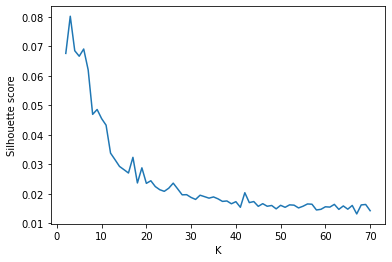

In [35]:
# Convert to dataframe
silhouettes_df = pd.DataFrame(silhouettes)

# Plot the data
plt.plot(silhouettes_df.k, silhouettes_df.score)
plt.xlabel("K")
plt.ylabel("Silhouette score")

In [33]:
silhouettes_df.score.idxmax() + 2

3

In [42]:
# Perform kmean clustering with 20 clusters
num_clusters = 3
clustering_model = KMeans(n_clusters=num_clusters)
clustering_model.fit(data_embeddings)
cluster_assignment = clustering_model.labels_

clustered_sentences = [[] for i in range(num_clusters)]
for sentence_id, cluster_id in enumerate(cluster_assignment):
    clustered_sentences[cluster_id].append(data['quotation'][sentence_id])

In [38]:
for i, cluster in enumerate(clustered_sentences):
    print("Cluster ", i+1)
    print(cluster[0:5])
    print("")

Cluster  1
["Anything less than women winning 50 per cent of new seats will be a loss not only for a progressive city's progress towards true gender equality but it would also be a loss for good governance in the ACT.", "I'd like to congratulate all the winners and finalists on their success. They have demonstrated clear leadership by moving women's progression from a `diversity' initiative to a core business priority. Achieving gender equality is only possible when men and women work together at every level, creating real change.", "I think what Deepika has spoken in the video makes sense. I do understand the counter argument too where everyone has been saying that had men said the same lines about having sex outside marriage being their choice, they would have been branded idiots or ass **** s. However, we still do have a clear cut demarcation or boundary as to what men and women are supposed to adhere to. It's great that the film has brought about a lot of questioning and debate. It

# Cosine similarity

In [22]:
# Source : https://www.sbert.net/docs/quickstart.html
model = SentenceTransformer('all-MiniLM-L6-v2')
sentences = clustered_sentences_30[0][0:100]
embeddings_sentences = model.encode(sentences)

#Compute cosine similarity between all pairs
cos_sim = util.cos_sim(embeddings_sentences, embeddings_sentences)

#Add all pairs to a list with their cosine similarity score
all_sentence_combinations = []
for i in range(len(cos_sim)-1):
    for j in range(i+1, len(cos_sim)):
        all_sentence_combinations.append([cos_sim[i][j], i, j])

#Sort list by the highest cosine similarity score
all_sentence_combinations = sorted(all_sentence_combinations, key=lambda x: x[0], reverse=True)

print("Top-5 most similar pairs:")
for score, i, j in all_sentence_combinations[0:5]:
    print("{} \t {} \t {:.4f}".format(sentences[i], sentences[j], cos_sim[i][j]))

Top-5 most similar pairs:
Billionaires should not exist, 	 Why do billionaires always do this? 	 0.6123
The fact that I know somebody who paid off $98,000 of my student loans makes me just want to go out and just give to people even more than I did before. 	 Why do they want to make interest-free loans to the government? If they just went out and met a noneconomist, they would find that people like 	 0.5540
I have to make money, and this is the best way I can make money. If you're not educated and have a good work ethic, you can come out here and still make six figures. 	 I never thought I'd make this much money, so a number is not going to stop me from working. 	 0.5247
When kids are struggling with a trillion and a half dollars in student loan debt, then I've got a problem with billionaires who are not paying their fair share, 	 The fact that I know somebody who paid off $98,000 of my student loans makes me just want to go out and just give to people even more than I did before. 	 0.

In [23]:
print("Top-5 least similar pairs:")
for score, i, j in all_sentence_combinations[-1:-6:-1]:
    print("{} \t {} \t {:.4f}".format(sentences[i], sentences[j], cos_sim[i][j]))

Top-5 least similar pairs:
This is not the same thing as Social Security. Because college is not for everybody. 	 At the farmer's market this weekend, pick up a couple of extra tomatoes and maybe an extra two million pounds of soybeans. 	 -0.1479
If we let ramps be sold for $2 a pound to someone who will sell them for $30 a pound? 	 This is not the same thing as Social Security. Because college is not for everybody. 	 -0.0988
I don't have any money. I'm just trying to get to work. 	 At the time of the transfer being made to Nissan, it was made clear that any losses would be borne by Mr. Ghosn, 	 -0.0980
A tax on periods is wrong, 	 simply one of numerous other investors in the company and is nothing more than a passive investor, 	 -0.0976
Every time you spend your money, I would argue you're voting, 	 At the time of the transfer being made to Nissan, it was made clear that any losses would be borne by Mr. Ghosn, 	 -0.0897
